# SI 618 - Homework #7: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

Version 2023.11.08.1.CT

This is, perhaps, one of the most exciting homework assignments that you have encountered in this course!

You are going to try your hand at a Kaggle competition to predict which passengers on board the Spaceship Titanic are transported to an alternate dimension.

You can access the competition here: **https://www.kaggle.com/c/spaceship-titanic**

This assignment is similar to the Kaggle competition that we did in class, but it uses a different and larger dataset.

The basic steps for this assignment are the same as what we did in class:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 80% accuracy will receive full points for
the accuracy component of this assignment.

Rubric:

1. (20 points) Conduct an EDA. You must demonstrate that you understand the data and the problem.
2. (60 points) Train, tune, and ensemble machine learning models.  You must use at least 3 different models, and you must ensemble them in some way.  You must also tune your models to improve accuracy.
4. (10 points) Accuracy score based on Kaggle submission report (or alternative, see NOTE above).
5. (10 points) PEP-8, grammar, spelling, style, etc.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/competitions/spaceship-titanic/code) (check the number of upvotes to help guide your exploration), but be careful to cite any code that you use, and be careful to not accidentally (or intentionally) cheat.

## GOOD LUCK!
(and don't cheat)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should
give you a sense of what makes a "good" notebook.

In [34]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [35]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [36]:
# Drop 'Transported' column
train_data.drop('Transported', axis=1, inplace=True)

print("Basic Information:")
print(train_data.info())
print("\n")

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
dtypes: float64(6), object(7)
memory usage: 883.0+ KB
None




* There are 8693 entries in the DataFrame, which means there are data records for 8693 passengers.

* The columns include identifiers like 'PassengerId', categorical features like 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', and continuous features like 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck'.

* The 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck' columns are of float64 type, indicating numerical values with decimals.

* There are missing values in several columns, as indicated by the non-null counts being less than the total number of entries (8693). For example, 'HomePlanet' has 8492 non-null entries, meaning there are 201 missing values.

In [37]:
# Distribution of Categorical Features
print("Categorical Features Distribution:")
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    print(train_data[col].value_counts())
    print("\n")

Categorical Features Distribution:
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64


False    5439
True     3037
Name: CryoSleep, dtype: int64


TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


False    8291
True      199
Name: VIP, dtype: int64




* HomePlanet: This feature indicates the planet from which passengers have departed. The majority are from Earth (4602 passengers), followed by Europa (2131 passengers), and Mars (1759 passengers).

* CryoSleep: A boolean feature indicating whether passengers were put into suspended animation. A larger number of passengers (5439) did not opt for cryosleep, while a smaller number (3037) did.

* Destination: The destination planet to which passengers are traveling. The most common destination is TRAPPIST-1e (5915 passengers), followed by 55 Cancri e (1800 passengers), and the least common is PSO J318.5-22 (796 passengers).

* VIP: This boolean feature indicates whether the passenger has paid for VIP service during the voyage. Only a small fraction of passengers (199) are VIPs, whereas the vast majority (8291) are not.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

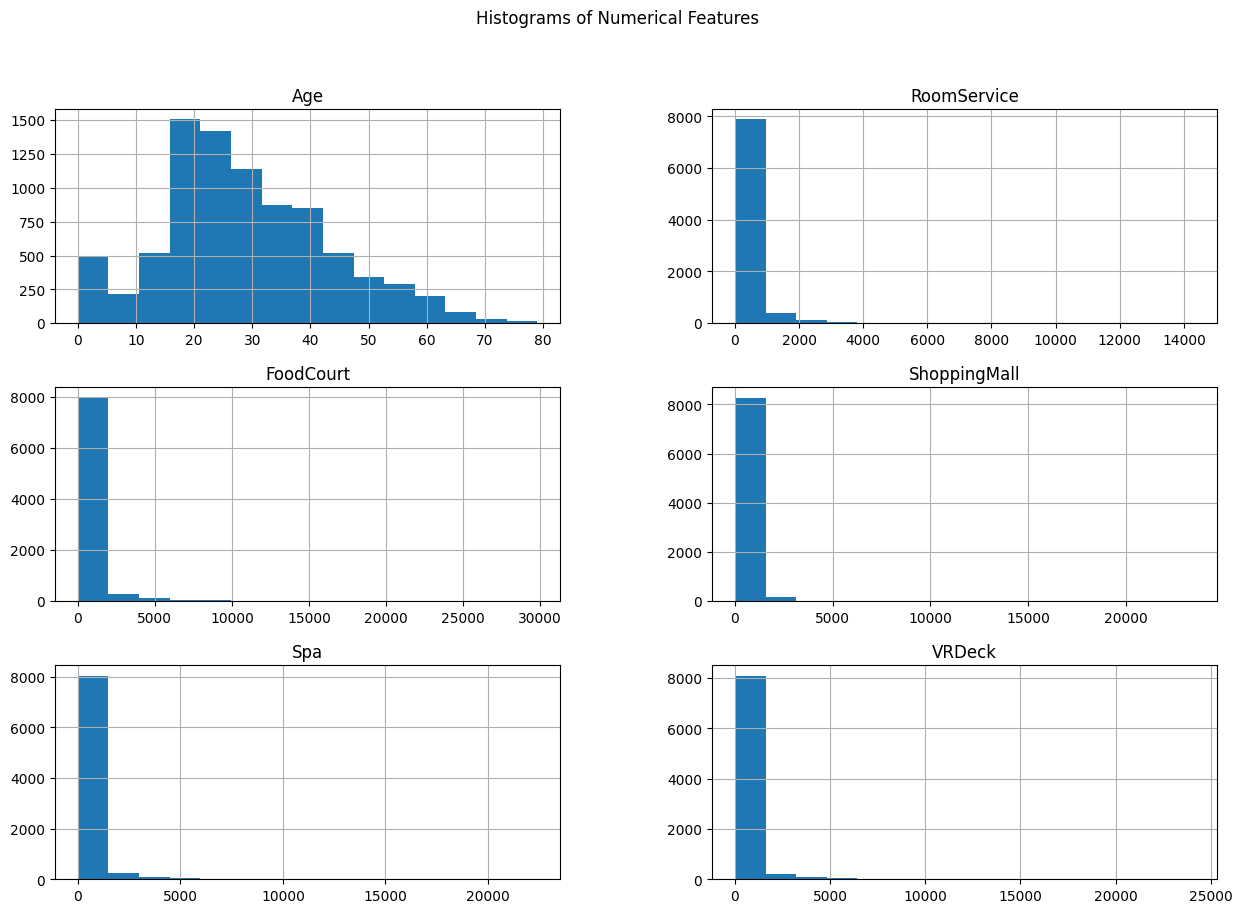

In [39]:
# Histograms for Numerical Features
train_data.hist(bins=15, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

* Age: The distribution is roughly bell-shaped, skewed slightly to the right, indicating a younger passenger demographic with a majority of passengers between approximately 20 and 40 years old.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Each of these features has a highly skewed distribution with the majority of values clustered near zero. This suggests that most passengers spent little to no money on these amenities. There are a few passengers who have high expenditures in these categories, indicating a small number of outliers with high spending.

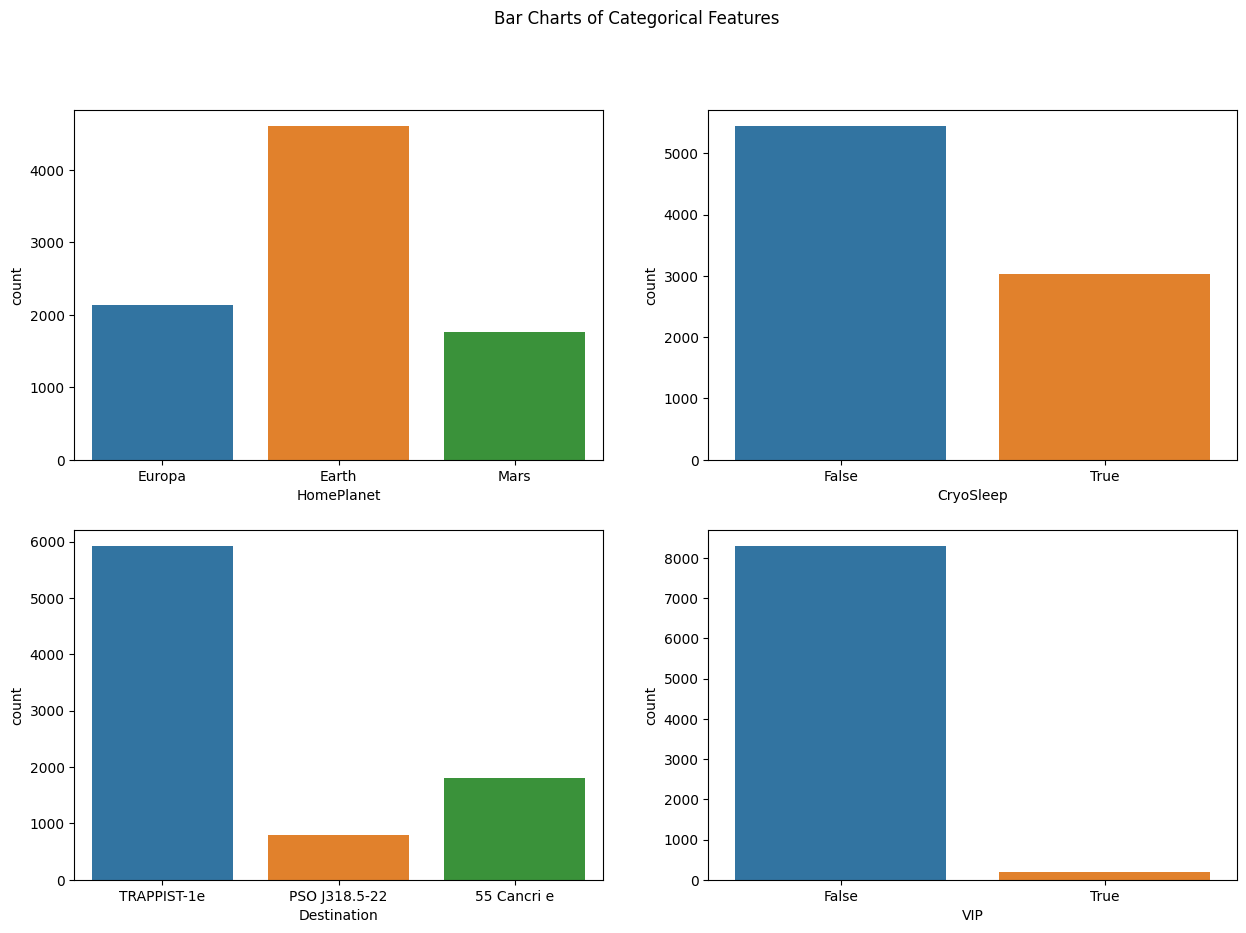

In [40]:
# Bar Charts for Categorical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(x='HomePlanet', data=train_data, ax=axes[0, 0])
sns.countplot(x='CryoSleep', data=train_data, ax=axes[0, 1])
sns.countplot(x='Destination', data=train_data, ax=axes[1, 0])
sns.countplot(x='VIP', data=train_data, ax=axes[1, 1])
plt.suptitle("Bar Charts of Categorical Features")
plt.show()

* HomePlanet: Earth is the most common home planet among passengers, followed by Europa, with Mars having the fewest passengers.

* CryoSleep: A larger number of passengers chose not to be in CryoSleep compared to those who did.

* Destination: TRAPPIST-1e is the most popular destination, while 55 Cancri e and PSO J318.5-22 have fewer passengers heading to them, with PSO J318.5-22 being the least common.

* VIP: The vast majority of passengers did not have VIP status, indicated by a much larger bar for 'False' compared to 'True'.

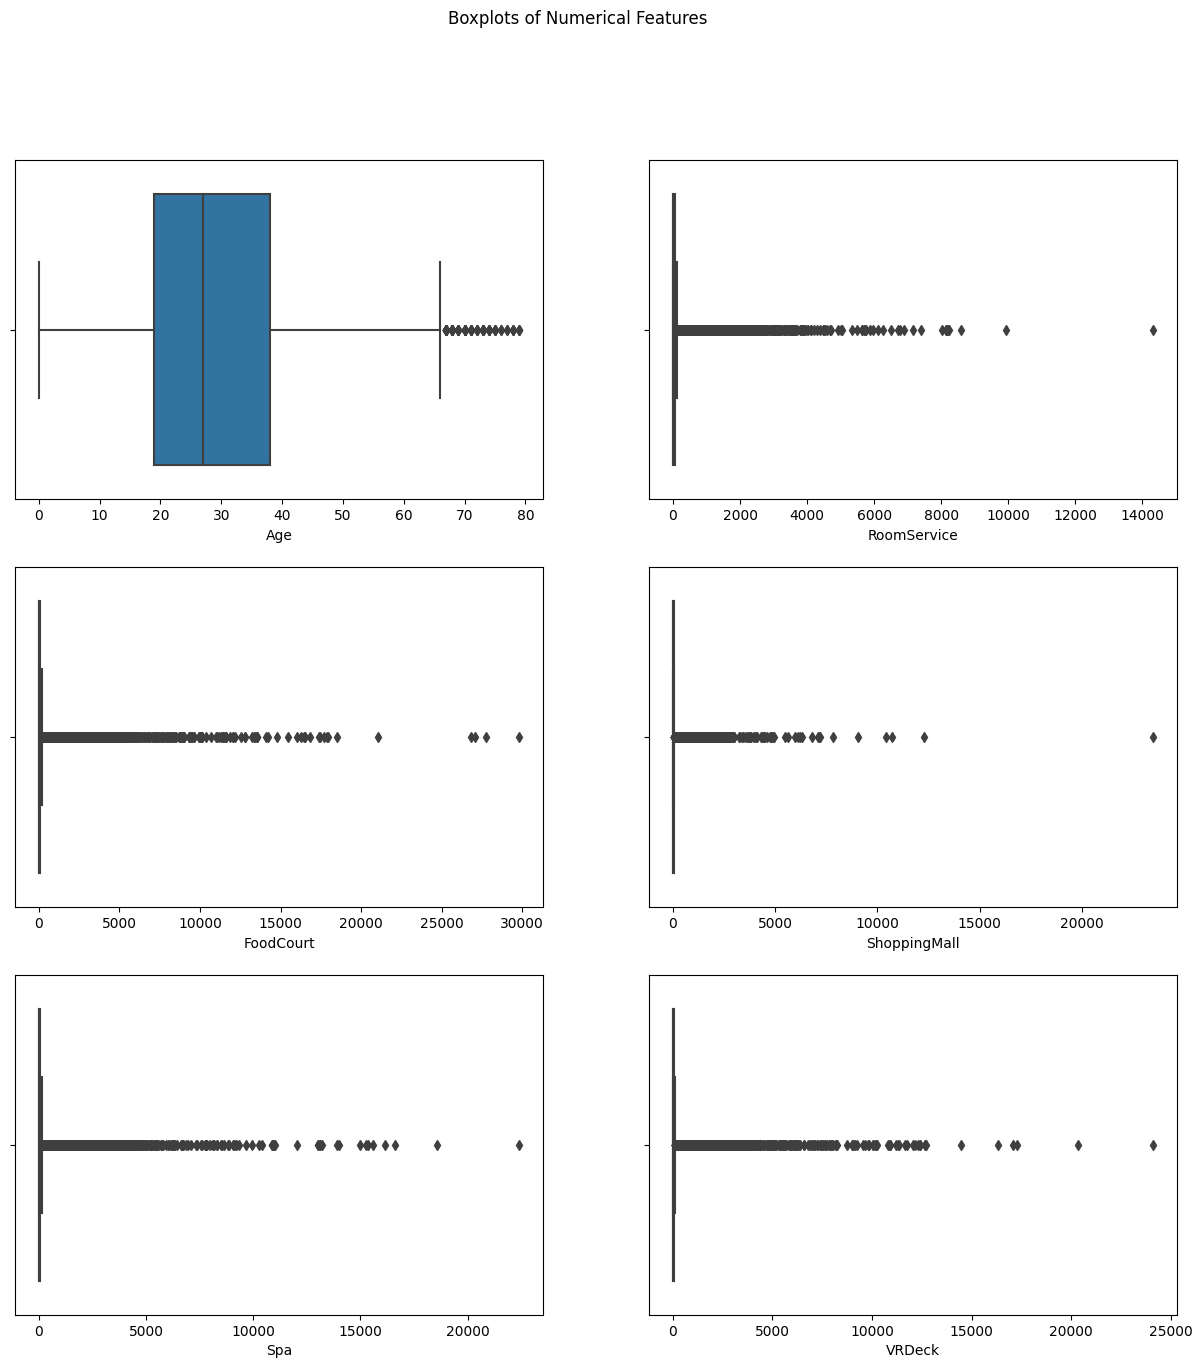

In [41]:
# Boxplots for Numerical Features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
sns.boxplot(x='Age', data=train_data, ax=axes[0, 0])
sns.boxplot(x='RoomService', data=train_data, ax=axes[0, 1])
sns.boxplot(x='FoodCourt', data=train_data, ax=axes[1, 0])
sns.boxplot(x='ShoppingMall', data=train_data, ax=axes[1, 1])
sns.boxplot(x='Spa', data=train_data, ax=axes[2, 0])
sns.boxplot(x='VRDeck', data=train_data, ax=axes[2, 1])
plt.suptitle("Boxplots of Numerical Features")
plt.show()

* Age: The boxplot for age shows a median around 30, with the interquartile range (IQR) spanning from approximately 20 to 40 years old. The data points are symmetrically distributed, with some outliers on the higher end.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Each of these boxplots indicates expenditures with most medians close to zero, suggesting low overall spending. The IQR is small, which means that there isn't much variability in spending for the middle half of the passengers. However, there are many outliers, with some extreme values indicating that a few passengers spent significantly more on these amenities.

<ipython-input-42-8628617e4d8e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='viridis')


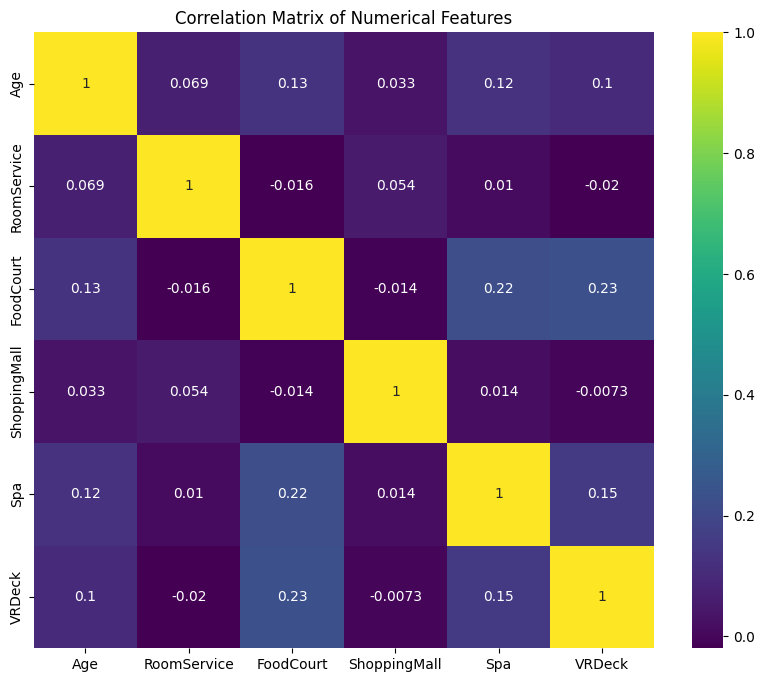

In [42]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='viridis')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

* Age has a low positive correlation with FoodCourt and VRDeck spending, suggesting that older passengers might spend slightly more on these amenities. The correlation with other features is negligible.

* RoomService spending has no strong correlations with any other features, indicating that the amount spent on room service is independent of age or other spending habits.

* FoodCourt shows a moderate positive correlation with VRDeck spending (0.23), suggesting that passengers who spend more on the FoodCourt also tend to spend somewhat more on the VRDeck.

* ShoppingMall has a very weak or no correlation with other features.

* Spa spending has a moderate positive correlation with FoodCourt (0.22) and VRDeck (0.15), implying that passengers who spend on one are likely to spend on the others.

* VRDeck shows a similar pattern to FoodCourt and Spa, with moderate correlations, indicating spending in one area is associated with spending in the others.

In [43]:
for column in train_data.columns:
    unique_values = train_data[column].unique()
    unique_count = len(unique_values)
    print(f"Column: {column}")
    print(f"Unique values count: {unique_count}")
    print(unique_values)
    print("\n")

Column: PassengerId
Unique values count: 8693
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']


Column: HomePlanet
Unique values count: 4
['Europa' 'Earth' 'Mars' nan]


Column: CryoSleep
Unique values count: 3
[False True nan]


Column: Cabin
Unique values count: 6561
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']


Column: Destination
Unique values count: 4
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


Column: Age
Unique values count: 81
[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]


Column: VIP
Unique values count: 3
[False True nan]


Column: RoomService
Unique values count: 1274
[   0.  109.   43. ... 1569. 8586.  745.]


Column: FoodCourt
Unique values count: 15

In [44]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [45]:
# Preprocess data
def preprocess_data(data, is_train=True):
    # Impute missing values for all columns
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    for col in numeric_cols:
        data[col] = imputer.fit_transform(data[[col]])

    # Extract features from 'Cabin'
    data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)

    # Drop unnecessary columns
    columns_to_drop = ['Cabin', 'Name']
    if is_train:
        columns_to_drop.append('PassengerId')
    data.drop(columns_to_drop, axis=1, inplace=True)

    return data

train_data = preprocess_data(train_data, is_train=True)
test_data = preprocess_data(test_data, is_train=False)


The preprocess_data function handles missing values in numerical columns by imputing them with the mean of each column. It also extracts separate features from the 'Cabin' column into 'Deck', 'Num', and 'Side'. Unnecessary columns such as 'Cabin' and 'Name' are dropped from both training and test data, and 'PassengerId' is additionally dropped from the training data only.

In [46]:
# Save PassengerId for submission
test_passenger_ids = test_data['PassengerId']

# One-hot encoding for categorical features
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
numeric_features = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

The given code snippet is for preprocessing the test dataset for a machine learning model. It first saves the 'PassengerId' for later use in the submission file. Then, it sets up a preprocessing pipeline with a ColumnTransformer that applies mean imputation to numeric features and one-hot encoding to categorical features, handling any unknown categories encountered in the test set by ignoring them.

In [47]:
# Create a voting classifier with XGBoost
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = GradientBoostingClassifier(n_estimators=100)
clf3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

voting_clf = VotingClassifier(estimators=[
    ('rf', clf1), ('gb', clf2), ('xgb', clf3)
], voting='soft')

The code sets up a voting classifier combining three different ensemble machine learning models: a Random Forest, a Gradient Boosting classifier, and an XGBoost classifier. It uses 'soft' voting, which means that the predicted probabilities of class labels are averaged across the three classifiers to determine the final prediction.

In [48]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', voting_clf)])

In [49]:
# Train the model
X = train_data.drop('Transported', axis=1)
y = train_data['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side'])])),
                ('classifier',
                 VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                                              ('gb',
                                               Gradie...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                  voting='soft'))])


The code snippet creates a machine learning pipeline that first applies preprocessing (imputation and one-hot encoding) to the data and then fits a voting classifier model composed of three different classifiers. The model is trained on the training subset of the data with the aim to predict the 'Transported' target variable.

In [50]:
# Predict on test data
predictions = pipeline.predict(test_data.drop('PassengerId', axis=1))

# Prepare submission file
submission = pd.DataFrame({'PassengerId': test_passenger_ids, 'Transported': predictions})
submission.to_csv('submission.csv', index=False)


Submission are saved into submission.csv file

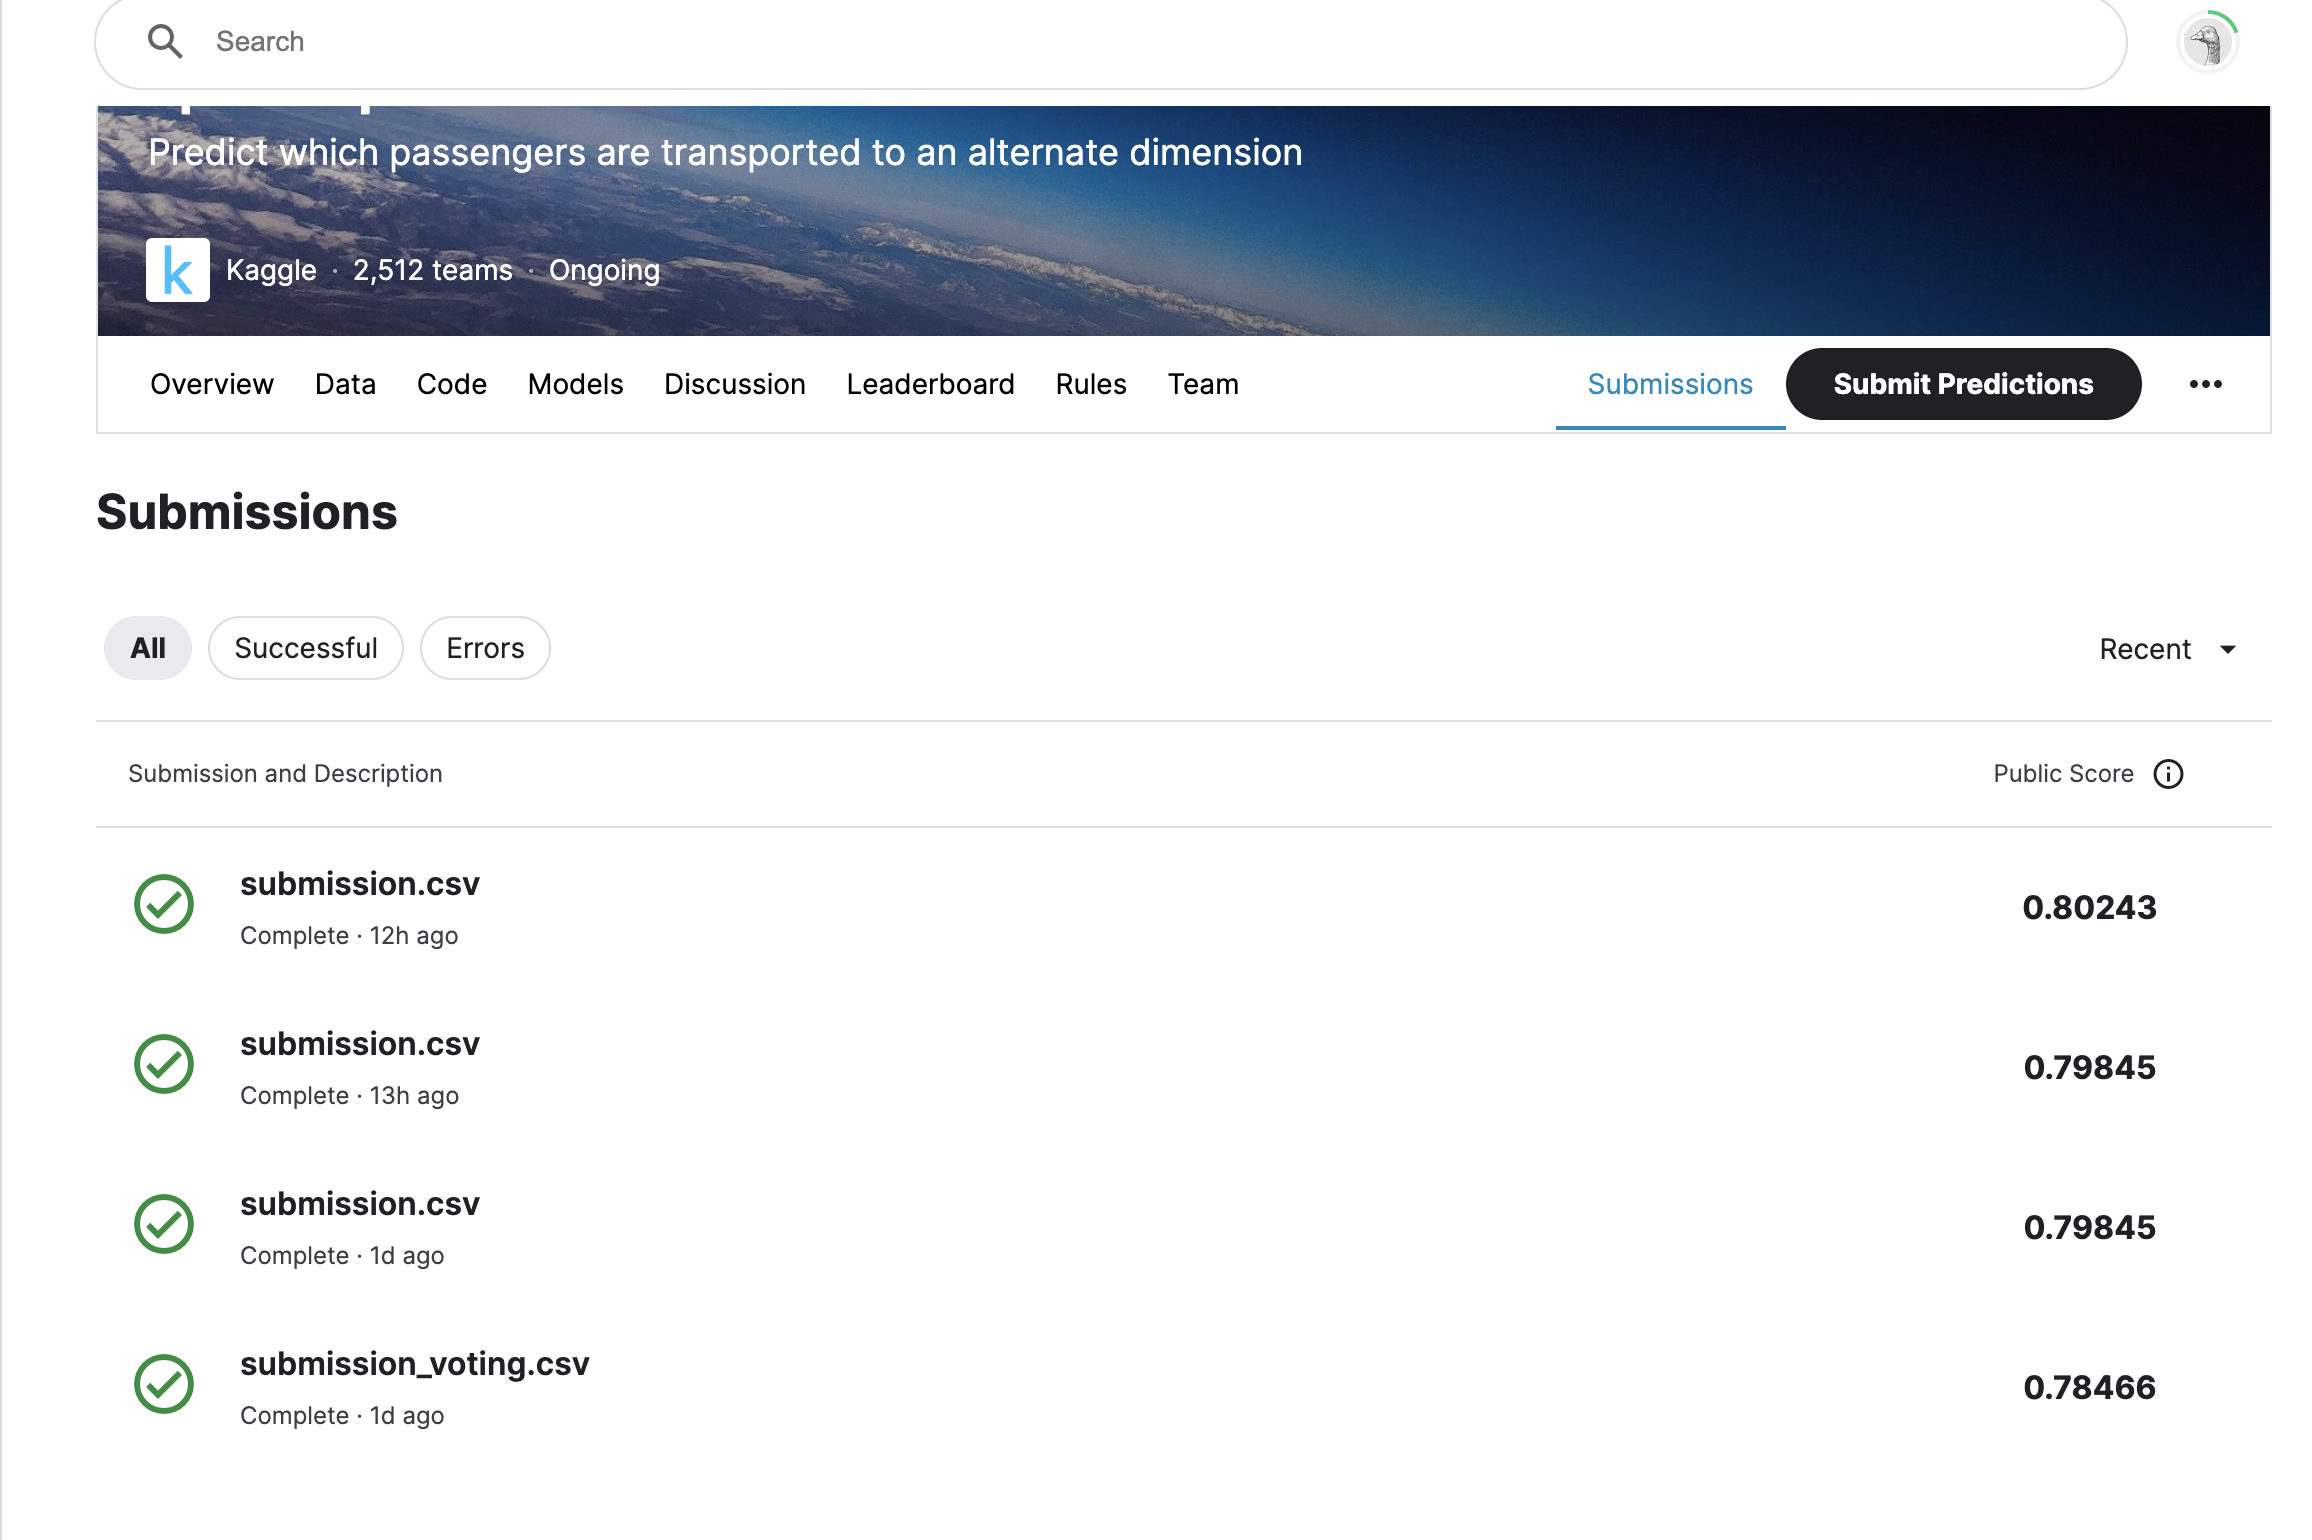